In [1]:
from matplotlib import pyplot as plt

import xarray as xr
import netCDF4 as nc
import numpy as np

import os

import datetime as dt
import pickle

from sklearn.model_selection import train_test_split
from sklearn.linear_model import RidgeCV, Ridge, LinearRegression, Lasso, ElasticNet
from sklearn.kernel_ridge import KernelRidge
from sklearn.metrics import r2_score
import random
from tqdm import tqdm
from collections import Counter
from sklearn.ensemble import RandomForestRegressor

In [2]:
models = ['CanESM5', 'MIROC-ES2L', 'MPI-ESM1-2-LR', 'MIROC6', 'CESM2']

In [3]:
def load_model_data(model, var, path='../data/'):
    # Loading data file
    file_path = os.path.join(path, '{}_{}.nc'.format(model, var))
    ds = xr.open_dataset(file_path)
    # Getting TAS
    tas_array = ds[var].values
    # Close the dataset
    ds.close()
    return tas_array

def get_data_shape_lat_lon(model='CanESM5', var='tas', path='../data/'):
    file_path = os.path.join(path, '{}_{}.nc'.format(model, var))
    ds = xr.open_dataset(file_path)
    # Getting TAS
    shape = ds[var].values.shape
    # Close the dataset
    ds.close()
    return shape, ds['lat'], ds['lon']

def load_data_models(models, var='tas', n_sample=10, path='../data/', coarse=12):
    X, y = None, None
    for model in models:
        tas_array = load_model_data(model, var=var, path=path)
        shape = tas_array.shape
        
        idxs = random.sample(range(shape[0]*shape[1]), n_sample)
        X_temp = tas_array.reshape(shape[0]*shape[1], shape[2]//coarse, coarse, shape[3]//coarse, coarse).mean(axis=(2,4))
        X_temp = X_temp.reshape(shape[0]*shape[1], shape[2]*shape[3]//(coarse**2))
        y_temp = np.tile(tas_array.mean(axis=0), (shape[0], 1, 1)) .reshape(shape[0]*shape[1], shape[2]*shape[3])

        if X is None:
            X = X_temp[idxs,:]
            y = y_temp[idxs,:]
        else :
            X = np.vstack((X, X_temp[idxs,:]))
            y = np.vstack((y, y_temp[idxs,:]))
        del tas_array
        del X_temp
        del y_temp
    return X, y

In [4]:
shape, lat, lon = get_data_shape_lat_lon()
d = shape[2]*shape[3]

In [5]:
B = 8 
models_test = random.choices(models, k=B)
models_train = [[model for model in models if model != model_test ] for model_test in models_test ]

In [6]:
occurence_models_test = Counter(models_test)

In [7]:
occurence_models_test

Counter({'MIROC6': 2, 'MIROC-ES2L': 2, 'MPI-ESM1-2-LR': 3, 'CanESM5': 1})

In [8]:
N = 250
coarse = 12

In [9]:
weights = {model: None for model in models}
for i in tqdm(range(len(models_test))):
    m_train, m_test = models_train[i], models_test[i]
    #print('Fitting optimal ridge {}/{}'.format(i, B))
    print("Extracting data...", end='\r')
    X_train, Y_train = load_data_models(m_train, n_sample=N, coarse=coarse)
    X_test, Y_test = load_data_models([m_test], n_sample=N, coarse=coarse)
    print("Data extracted!")
    
    #idx = random.choices([0, 1, 2, 3])[0]
    #idx_val = list(range(idx*N, (idx+1)*N))
    #idx_train = list(list(range(0, idx*N))+ list(range(idx*N, 4*N)))
    print("Training ridge regression...", end='\r')
    rf = RandomForestRegressor(n_estimators=10, max_leaf_nodes=5) #cv=zip(idx_val, idx_val))
    rf.fit(X_train, Y_train)
    print("Ridge regression fitted!")
    print('Saving weights...', end='\r')
    if weights[m_test] is None:
        weights[m_test] = rf.estimators_
    else:
        for estimator in rf.estimators_ : weights[m_test].append(estimator)
    print("Weights saved!")
# Save the weights for this alpha to a file
file_path = f'../weights/RandomForest_trees_n{N}_coarse{coarse}.pkl'
with open(file_path, 'wb') as f:
    pickle.dump(weights, f)

  0%|          | 0/8 [00:00<?, ?it/s]

Data extracted!...


 12%|█▎        | 1/8 [01:10<08:15, 70.76s/it]

Ridge regression fitted!
Weights saved!...
Data extracted!...


 25%|██▌       | 2/8 [02:23<07:11, 71.96s/it]

Ridge regression fitted!
Weights saved!...
Data extracted!...


 38%|███▊      | 3/8 [04:08<07:15, 87.08s/it]

Ridge regression fitted!
Weights saved!...
Data extracted!...


 50%|█████     | 4/8 [05:58<06:24, 96.00s/it]

Ridge regression fitted!
Weights saved!...
Data extracted!...


 62%|██████▎   | 5/8 [07:30<04:43, 94.57s/it]

Ridge regression fitted!
Weights saved!...
Data extracted!...


 75%|███████▌  | 6/8 [09:01<03:06, 93.46s/it]

Ridge regression fitted!
Weights saved!...
Data extracted!...


 88%|████████▊ | 7/8 [10:44<01:36, 96.55s/it]

Ridge regression fitted!
Weights saved!...
Data extracted!...


100%|██████████| 8/8 [12:33<00:00, 94.16s/it] 

Ridge regression fitted!
Weights saved!...


In [10]:
file = f'../weights/RandomForest_trees_n{N}_coarse{coarse}.pkl'
with open(file, 'rb') as f:
    weights = pickle.load(f)

In [22]:
R = 10
scores_pattern = {model:[] for model in models}
for b in tqdm(range(R)):
    for model in ['MIROC6', 'MIROC-ES2L', 'MPI-ESM1-2-LR', 'CanESM5']:
        X_test, Y_test = load_data_models([model], var='tas', n_sample=N, coarse=coarse)
        rf = RandomForestRegressor(n_estimators=1, max_leaf_nodes=2)
        rf.fit(X_test, Y_test)
        rf.estimators_ = weights['CanESM5']
        Y_pred = rf.predict(X_test) 
        score_pattern = r2_score(Y_test, Y_pred, multioutput='raw_values')
        scores_pattern[model].append(score_pattern)


  0%|          | 0/10 [00:00<?, ?it/s]

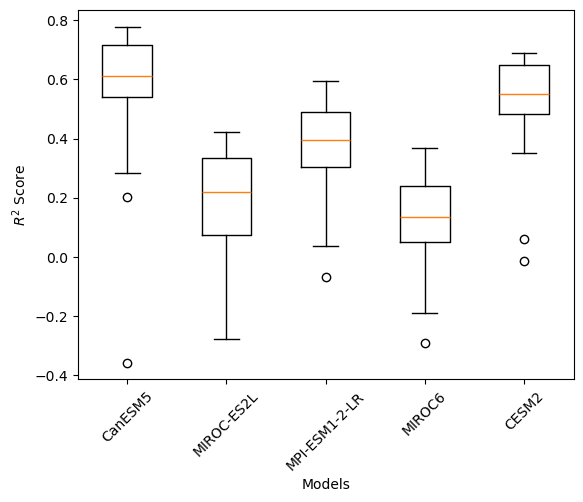

In [ ]:
plt.boxplot([np.mean(scores_pattern[model], axis=1) for model in models])
# Boxplot
# Set xticklabels with alpha values
plt.xticks(range(1, len(models) + 1), [model for model in models], rotation=45)

# Set xlabel with alphas
plt.xlabel(r'Models')

# Set ylabel with r2 score
plt.ylabel(r'$R^2$ Score')

directory = '../Results'
plt.savefig(directory + "/R2_ridge_stability_coarse12.pdf", format="pdf", bbox_inches="tight")

plt.show()

In [ ]:
model = 'MIROC6'
scores_pattern_maps = np.mean(scores_pattern[model], axis=0).reshape(len(lat), len(lon))

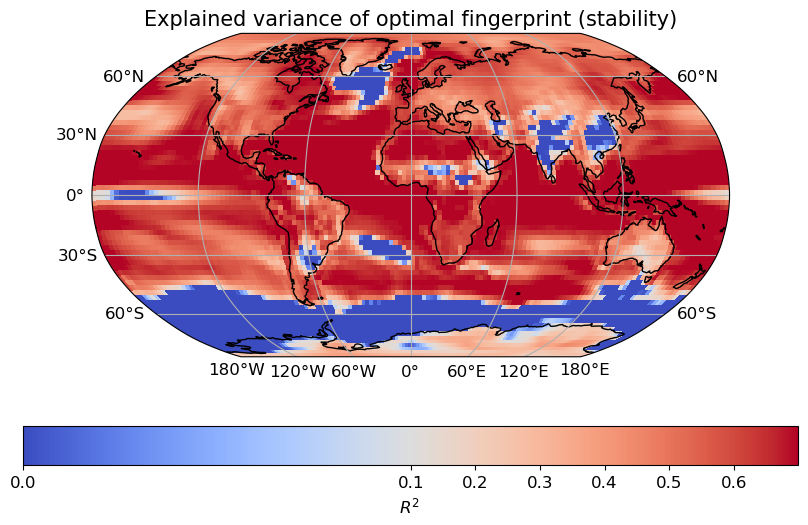

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from matplotlib.colors import TwoSlopeNorm

# Assuming you have defined lat, lon, diff_r2_map, diff_corr_map, max_val_r2, max_val_corr

# Plotting
fig = plt.figure(figsize=(10, 6))
ax = plt.axes(projection=ccrs.Robinson())

# Plot for diff_r2_map
norm_r2 = TwoSlopeNorm(vmin=.0, vcenter=0.1, vmax=0.7)
contour_r2 = ax.pcolormesh(lon, lat, scores_pattern_maps, transform=ccrs.PlateCarree(), cmap='coolwarm', norm=norm_r2)
ax.coastlines()

gl = ax.gridlines(draw_labels=True)
gl.top_labels = gl.right_labels = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 12}  # Longitude font size
gl.ylabel_style = {'size': 12}  # Latitude font size

ax.set_title(r'Explained variance of optimal fingerprint (stability)', fontsize=15)

cb = plt.colorbar(contour_r2, ax=ax, label='R2 score differences', orientation='horizontal')
cb.ax.tick_params(labelsize=12)
cb.set_label(r'$R^2$ ', fontsize=12) 

directory = '../Results'
plt.savefig(directory + "/maps_R2_ridge_stability_coarse_{}_{}.pdf".format(coarse, model), format="pdf", bbox_inches="tight")


plt.show()